# I. Training: 모델 학습, 설계, 가중치 저장

## 1. 데이터 준비 및 분할

### 1-1. 모델 선택
독일어, 영어 등이 혼용되어 있는 training data set의 특성을 고려하여 pretrained 다국어 BERT를 선택

In [ ]:
# =========================================================
# 필수 라이브러리 설치
# =========================================================

# transformer 모델
!pip install transformers torch

# git clone
!git clone https://github.com/jsjang0104/HUFS-LAI-ML-2025-2.git

# 허깅 페이스
!pip install huggingface_hub -q
!pip install accelerate -q

Cloning into 'HUFS-LAI-ML-2025-2'...
remote: Enumerating objects: 498, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 498 (delta 140), reused 67 (delta 67), pack-reused 293 (from 1)
Receiving objects: 100% (498/498), 4.84 MiB | 10.49 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [ ]:
# =========================================================
# mBERT 모델 및 토크나이저 로드
# =========================================================

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. 모델 이름 정의: mBERT의 기본 모델명
MODEL_NAME = "bert-base-multilingual-cased"

# 2. 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # AutoTokenizer는 지정된 MODEL_NAME에 맞는 토크나이저를 자동으로 로드

# 3. 모델 로드
# Sequence classification model: 사전 학습된 BERT 가중치에 Classification Head가 붙어있는 형태
model = AutoModelForSequenceClassification.from_pretrained(
  MODEL_NAME,
  num_labels=4
)

print(f"모델 로드 완료: {MODEL_NAME}")
print(f"모델 아키텍처:\n{model}")

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델 로드 완료: bert-base-multilingual-cased
모델 아키텍처:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
  

### 1-2. 하이퍼파라미터

In [ ]:
LEARNING_RATE = 2e-5 # 학습률
DROPOUT_RATE = 0.2 # 드롭아웃 비율
RANDOM_SEED = 42 # 난수: 시드 고정 (재현성 확보)
N_EPOCHS = 3 # 에포크 수: BERT 파인튜닝은 일반적으로 2~4 epoch 수행
BATCH_SIZE = 12 # 배치 사이즈

# NOTE: Training progress bar appears empty because the `train_epoch` function in cell `GapN5pfR9iSy`
# incorrectly returns after the first batch. To fix this, move the `return` statement
# out of the `for` loop in the `train_epoch` function definition.

### 1-3. 데이터 로드 및 분할

In [ ]:
# =======================================================
# 작업 디렉토리 설정
# =======================================================

%cd HUFS-LAI-ML-2025-2

import pandas as pd

DATA_PATH = 'submissions/202400420/assignment4/data/training_data.csv'
df = pd.read_csv(DATA_PATH)

print(f"GitHub에서 데이터 로드 성공! 총 레코드 수: {len(df)}")

[Errno 2] No such file or directory: 'HUFS-LAI-ML-2025-2'
/content/HUFS-LAI-ML-2025-2
GitHub에서 데이터 로드 성공! 총 레코드 수: 28525


In [ ]:
# =========================================================
# 데이터 로드
# =========================================================

import pandas as pd
import os

DATA_PATH = "/content/drive/MyDrive/ML_assignment_2025-2/training_data.csv"

# 데이터프레임으로 로드
try:
  df = pd.read_csv(DATA_PATH)

  print(f"데이터 로드 성공. 총 레코드 수: {len(df)}")
  print("\n데이터 미리보기:")
  print(df.head())

except FileNotFoundError:
  print(f"오류: 지정된 경로에 파일이 없습니다. 경로를 다시 확인해주세요: {DATA_PATH}")

# 로드된 데이터프레임의 컬럼명과 정보 확인
df.info()

데이터 로드 성공. 총 레코드 수: 28525

데이터 미리보기:
                                               title              author  \
0                          aus der knabenzeit (1852)        karl gutzkow   
1                                 friedrich schiller  joseph schreyvogel   
2                                 lebenserinnerungen     levin schücking   
3  il linguaggio segreto di dante e dei "fedeli d...         luigi valli   
4                                    tolstoy the man            edward a   

     subject  
0  Literatur  
1  Literatur  
2  Literatur  
3  Literatur  
4  Literatur  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28525 entries, 0 to 28524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    28525 non-null  object
 1   author   28525 non-null  object
 2   subject  28525 non-null  object
dtypes: object(3)
memory usage: 668.7+ KB


In [ ]:
# =========================================================
# 클래스 가중치 계산 (클래스 불균형 고려)
# =========================================================

# 'subject'열을 기준으로 클래스별 빈도수 계산
class_counts = df['subject'].value_counts()
total_samples = len(df)
num_classes = len(class_counts)

# 클래스 인덱스 매핑 (문학=0, 어학=1, 역사=2, 사회과학=3)
class_to_idx = {name: i for i, name in enumerate(class_counts.index.tolist())}
print("클래스-인덱스 매핑:", class_to_idx)

# 각 클래스에 할당할 가중치 배열 초기화
class_weights = [0.0] * num_classes

# 빈도수의 역수를 기반으로 가중치 계산 (빈도수가 적을수록 가중치 높아짐)
for subject, count in class_counts.items():
  weight = total_samples / (num_classes * count)
  idx = class_to_idx[subject]
  class_weights[idx] = weight

print(f"\n계산된 클래스 가중치 (순서: {list(class_to_idx.keys())}):")
print(class_weights)

# PyTorch 텐서 형태로 변환 (Loss 함수 입력용)
import torch
weights_tensor = torch.tensor(class_weights, dtype=torch.float)

클래스-인덱스 매핑: {'Geschichte': 0, 'Literatur': 1, 'Sozialwissenschaften': 2, 'Sprachwissenschaft': 3}

계산된 클래스 가중치 (순서: ['Geschichte', 'Literatur', 'Sozialwissenschaften', 'Sprachwissenschaft']):
[0.7520035853632817, 0.7933307375681389, 0.9277026148042149, 3.01405325443787]


In [ ]:
# =========================================================
# 데이터셋 분할 (Train/Validation/Test Split)
# =========================================================

from sklearn.model_selection import train_test_split

# 1. Test Set (10%) 분리: 계층적 샘플링 적용
train_val_df, test_df = train_test_split(
  df,
  test_size=0.10,
  random_state=RANDOM_SEED,
  stratify=df['subject']
)

# 2. Train Set (80%), Validation Set (10%) 분리: 계층적 샘플링 적용
val_size_ratio = 0.10 / 0.90 # (전체 10% / 남은 90%)
train_df, val_df = train_test_split(
  train_val_df,
  test_size=val_size_ratio,
  random_state=RANDOM_SEED,
  stratify=train_val_df['subject']
)

print(f"\n분할 결과: Train={len(train_df)} | Validation={len(val_df)} | Test={len(test_df)}")

# 3. (점검용) 분할 결과 클래스 분포 확인 코드 ('subject' 컬럼에 대한 클래스 분포)
def get_class_distribution(df):
  distribution = df['subject'].value_counts(normalize=True).mul(100).rename('Percentage')
  return distribution

# 각 데이터셋의 클래스 분포 계산
original_dist = get_class_distribution(df)
train_dist = get_class_distribution(train_df)
val_dist = get_class_distribution(val_df)
test_dist = get_class_distribution(test_df)

# 결과를 하나의 표로 합치기
distribution_summary = pd.DataFrame({
  'Original': original_dist,
  'Train': train_dist,
  'Validation': val_dist,
  'Test': test_dist
})

# 소수점 둘째 자리까지 표시
distribution_summary = distribution_summary.sort_index().round(2)

print("--- 데이터셋 클래스 분포 비교 (단위: %) ---")
print(distribution_summary)


분할 결과: Train=22819 | Validation=2853 | Test=2853
--- 데이터셋 클래스 분포 비교 (단위: %) ---
                      Original  Train  Validation   Test
subject                                                 
Geschichte               33.24  33.25       33.23  33.23
Literatur                31.51  31.51       31.51  31.51
Sozialwissenschaften     26.95  26.95       26.95  26.95
Sprachwissenschaft        8.29   8.29        8.31   8.31


In [ ]:
# =========================================================
# 분할된 데이터셋 (Train/Validation/Test) 파일 저장
# =========================================================

# 파일이 저장 경로와 파일명 정의
BASE_OUTPUT_DIR = '/content/temp_data/'# 코랩 내 오류로 인해 clone한 git 경로에 저장이 안 돼서 임시로 저장
TRAIN_DATA_PATH = os.path.join(BASE_OUTPUT_DIR, 'train_data.csv')
VAL_DATA_PATH   = os.path.join(BASE_OUTPUT_DIR, 'val_data.csv')
TEST_DATA_PATH  = os.path.join(BASE_OUTPUT_DIR, 'test_data.csv')

# 1. 저장 디렉터리 생성 (없으면 오류 방지)
if not os.path.exists(BASE_OUTPUT_DIR):
    os.makedirs(BASE_OUTPUT_DIR)
    print(f"✅ 디렉터리 생성: {BASE_OUTPUT_DIR}")


# 2. 각 데이터셋 저장
# index=False 옵션은 불필요한 인덱스 열이 파일에 저장되는 것을 방지

# Train Set 저장
train_df.to_csv(TRAIN_DATA_PATH, index=False)
print(f"✅ Train Set 저장 완료: '{TRAIN_DATA_PATH}'")

# Validation Set 저장
val_df.to_csv(VAL_DATA_PATH, index=False)
print(f"✅ Validation Set 저장 완료: '{VAL_DATA_PATH}'")

# Test Set 저장
test_df.to_csv(TEST_DATA_PATH, index=False)
print(f"✅ Test Set 저장 완료: '{TEST_DATA_PATH}'")

✅ 디렉터리 생성: /content/temp_data/
✅ Train Set 저장 완료: '/content/temp_data/train_data.csv'
✅ Validation Set 저장 완료: '/content/temp_data/val_data.csv'
✅ Test Set 저장 완료: '/content/temp_data/test_data.csv'


### 1-4. 데이터 토크나이징 및 데이터 로더 생성

In [ ]:
# =========================================================
# 토크나이징 및 데이터 로더
# =========================================================

from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

# 모델 및 토크나이저 정의 (다국어 지원 모델)
MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 256 # assignment 4의 data 분석 결과(136자 이상)를 고려하여 256으로 설정

# Dataset 클래스 정의
class BookDataset(Dataset):
  def __init__(self, data_df, tokenizer, max_len, class_to_idx):
    self.texts = data_df['title'].tolist()
    self.labels = data_df['subject'].map(class_to_idx).tolist()
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = self.labels[idx]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

# Dataset 및 DataLoader 인스턴스 생성
train_dataset = BookDataset(train_df, tokenizer, MAX_LEN, class_to_idx)
val_dataset = BookDataset(val_df, tokenizer, MAX_LEN, class_to_idx)
test_dataset = BookDataset(test_df, tokenizer, MAX_LEN, class_to_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoader 준비 완료. Train Loader 배치 수: {len(train_loader)}")


DataLoader 준비 완료. Train Loader 배치 수: 1902


## 2. 모델 설계 및 학습

### 2-1. 모델 정의, GPU 설정 및 Loss/Optimizer 준비

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW
from torch import nn
# =========================================================
# GPU 및 시드 설정
# =========================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용할 디바이스: {device}")

# 재현 가능성을 위한 시드 고정 (이전에 사용된 시드와 동일하게 유지)
def set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
set_seed(42)

# =========================================================
# 모델 로드
# =========================================================
MODEL_NAME = "bert-base-multilingual-cased"
num_classes = len(class_to_idx)
model = AutoModelForSequenceClassification.from_pretrained(
  MODEL_NAME,
  num_labels=num_classes,
  hidden_dropout_prob=DROPOUT_RATE,
  attention_probs_dropout_prob=DROPOUT_RATE
)
model.to(device)

# =========================================================
# Optimizer 및 Loss 함수 설정
# =========================================================
# BERT 계열 학습에 적합한 AdamW 옵티마이저 사용
optimizer = AdamW(model.parameters(), LEARNING_RATE)

# Weighted Cross-Entropy Loss 적용 (클래스 불균형 해결)
# 1단계에서 계산한 weights_tensor를 여기에 사용
loss_fn = nn.CrossEntropyLoss(weight=weights_tensor.to(device))

# 모델 가중치 저장 경로
SAVE_DIR = 'submissions/202400420/assignment5'
SAVE_PATH = os.path.join(SAVE_DIR, 'best_bert_classifier_final.pth')

if not os.path.exists(SAVE_DIR):# 디렉토리가 존재하지 않으면 생성
  os.makedirs(SAVE_DIR, exist_ok=True)
  print(f"저장 디렉토리 생성 완료: {SAVE_DIR}")
else:
  print(f"저장 디렉토리가 이미 존재합니다: {SAVE_DIR}")
SAVE_PATH = './best_bert_classifier_final.pth'

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


사용할 디바이스: cuda
저장 디렉토리가 이미 존재합니다: submissions/202400420/assignment5


### 2-2. train, evaluation 함수 정의

In [ ]:
# =========================================================
# train, evaluation 함수 정의
# =========================================================

import numpy as np
import torch
from tqdm.auto import tqdm

# 1. Training
def train_epoch(model, data_loader, loss_fn, optimizer, device):
  model.train() # 모델을 훈련 모드로 설정

  losses = []
  correct_predictions = 0
  total_samples = 0

  # 진행률 바
  progress_bar = tqdm(data_loader, desc="Training")

  for batch in progress_bar:
    # 1. 데이터 GPU로 이동
    # DataLoader에서 정의한 key ('input_ids', 'attention_mask', 'labels') 사용
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    # 2. 그래디언트 초기화
    optimizer.zero_grad()

    # 3. Forward Propagation
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    # 4. Loss 계산 (Weighted Cross-Entropy Loss 사용)
    loss = loss_fn(outputs.logits, labels)

    # 5. 예측 및 정확도 계산
    _, preds = torch.max(outputs.logits, dim=1)
    correct_predictions += torch.sum(preds == labels).item()
    total_samples += labels.size(0)

    losses.append(loss.item())

    # 6. 역전파 및 가중치 업데이트
    loss.backward()

    # Gradient Clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    # tqdm에 현재 배치 Loss 표시
    progress_bar.set_postfix({'loss': f'{np.mean(losses):.4f}'})

  # Epoch 전체의 평균 Loss와 Accuracy 반환
  # NOTE: The return statement was moved outside the loop to correctly calculate metrics for the entire epoch.
  return np.mean(losses), correct_predictions / total_samples

# 2. Validation, Test
def eval_model(model, data_loader, loss_fn, device):
  model.eval()

  losses = []
  correct_predictions = 0
  total_samples = 0

  with torch.no_grad(): # 평가 시에는 그래디언트 계산 비활성화 (메모리 및 속도 최적화)
    for batch in data_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      loss = loss_fn(outputs.logits, labels)

      _, preds = torch.max(outputs.logits, dim=1)
      correct_predictions += torch.sum(preds == labels).item()
      total_samples += labels.size(0)

      losses.append(loss.item())

    # Epoch 전체의 평균 Loss와 Accuracy 반환
    return np.mean(losses), correct_predictions / total_samples

### 2-3. training and evaluation
최고의 validation accuracy를 가진 모델 저장 (투명성, 재현 가능성)

In [ ]:
import time
from collections import defaultdict
import torch.nn as nn

# 지표 추적을 위한 딕셔너리
history = defaultdict(list)
best_accuracy = 0

# 모델 가중치 저장 경로 (Google Drive에 저장하여 재현 가능성 확보)
# 이 경로는 README.md에 반드시 명시해야 합니다.
SAVE_PATH = './best_bert_classifier_final.pth'

print(f"\n--- 모델 학습 시작 (총 {N_EPOCHS} Epoch) ---")

for epoch in range(N_EPOCHS):
  start_time = time.time()
  print(f"\n======== Epoch {epoch + 1}/{N_EPOCHS} ========")

  # 1. Training (Loss, 성능 지표 추적)
  train_loss, train_acc = train_epoch(
    model,
    train_loader,
    loss_fn,
    optimizer,
    device
  )

  # 2. Validation (Validation 성능 모니터링)
  val_loss, val_acc = eval_model(
    model,
    val_loader,
    loss_fn,
    device
  )

  elapsed_time = time.time() - start_time

  # 학습 과정의 투명성 확보 (epoch별 지표 출력)
  print(f"경과 시간: {elapsed_time:.2f}초")
  print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

  # 3. 학습 곡선 시각화를 위한 지표 저장
  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(val_acc)

  # 4. 모델 가중치 저장 (최고 성능 모델)
  if val_acc > best_accuracy:
    best_accuracy = val_acc
    torch.save(model.state_dict(), SAVE_PATH)
    print(f"Validation Accuracy ({best_accuracy:.4f}) 개선. 모델 가중치 저장 완료.")

print("\n--- 모델 학습 완료 ---")


--- 모델 학습 시작 (총 3 Epoch) ---

======== Epoch 1/3 ========


Training:   0%|          | 0/1902 [00:00<?, ?it/s]

경과 시간: 1119.81초
Train Loss: 0.8993 | Train Acc: 0.6417
Val Loss: 0.8457 | Val Acc: 0.6937
Validation Accuracy (0.6937) 개선. 모델 가중치 저장 완료.

======== Epoch 2/3 ========


Training:   0%|          | 0/1902 [00:00<?, ?it/s]

경과 시간: 1121.87초
Train Loss: 0.7356 | Train Acc: 0.7259
Val Loss: 0.8676 | Val Acc: 0.6751

======== Epoch 3/3 ========


Training:   0%|          | 0/1902 [00:00<?, ?it/s]

경과 시간: 1121.53초
Train Loss: 0.6449 | Train Acc: 0.7655
Val Loss: 0.8276 | Val Acc: 0.7199
Validation Accuracy (0.7199) 개선. 모델 가중치 저장 완료.

--- 모델 학습 완료 ---


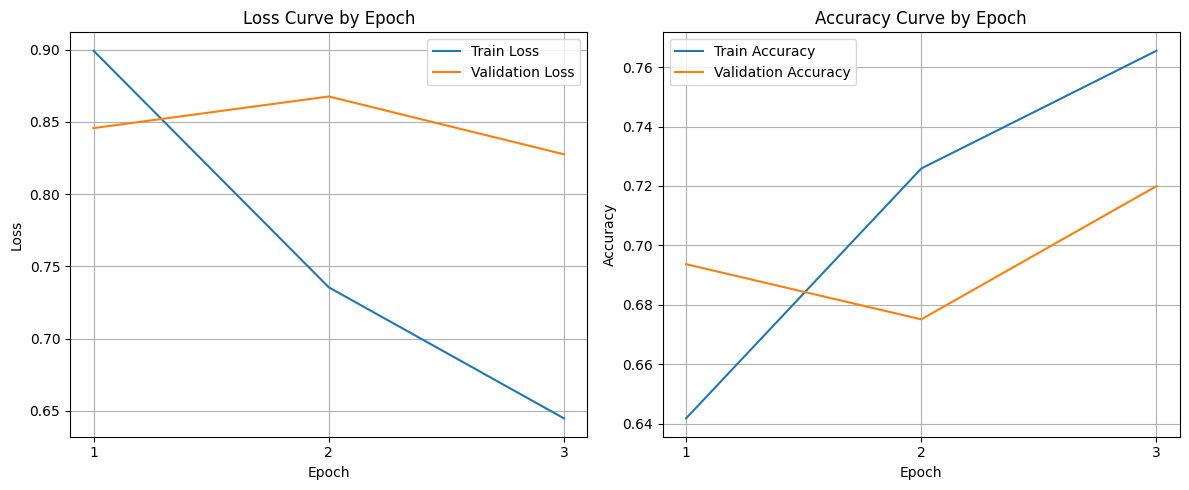

In [ ]:
# =========================================================
# Loss 및 Accuracy 시각화 (투명성)
# =========================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Epoch X-axis values
x_epochs = range(1, N_EPOCHS + 1)

# Loss 시각화
plt.subplot(1, 2, 1)
plt.plot(x_epochs, history['train_loss'], label='Train Loss')
plt.plot(x_epochs, history['val_loss'], label='Validation Loss')
plt.title('Loss Curve by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(x_epochs) # Ensure x-axis ticks match epoch numbers
plt.legend()
plt.grid(True)

# Accuracy 시각화
plt.subplot(1, 2, 2)
plt.plot(x_epochs, history['train_acc'], label='Train Accuracy')
plt.plot(x_epochs, history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Curve by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(x_epochs) # Ensure x-axis ticks match epoch numbers
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 2-4. Hugging Face 업로드

In [ ]:
# =========================================================
# 로그인 및 토큰 입력
# =========================================================

from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForSequenceClassification

notebook_login()

In [ ]:
# =========================================================
# HuggingFace 업로드 (재현성)
# =========================================================

# 로컬 파일에서 가중치 로드
LOAD_PATH = './best_bert_classifier_final.pth'
MODEL_NAME = "bert-base-multilingual-cased"
num_classes = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_to_upload = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes
)
model_to_upload.to(device)

model_to_upload.load_state_dict(torch.load(LOAD_PATH, map_location=device))

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 모델 및 토크나이저 업로드
HF_USERNAME = "jsjang0104"
HF_REPO_NAME = "book-genre-classifier-bert"

# Model Push
model_to_upload.push_to_hub(HF_REPO_NAME)
# Tokenizer Push
tokenizer.push_to_hub(HF_REPO_NAME)

print(f"모델 및 토크나이저가 Hugging Face Hub에 성공적으로 업로드되었습니다: {HF_USERNAME}/{HF_REPO_NAME}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...bls0h_x/model.safetensors:   0%|          |  555kB /  711MB            

README.md: 0.00B [00:00, ?B/s]

\모델 및 토크나이저가 Hugging Face Hub에 성공적으로 업로드되었습니다: jsjang0104/book-genre-classifier-bert
